In [1]:
import glob
import os

import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sn
import xarray as xr

plt.style.use("ggplot")

# Compare RADR modelled discharge to observed data for major Arctic rivers

## 1. Read observed data

Observed time series were cleaned and compiled by Leah based on data from ArcticGRO.

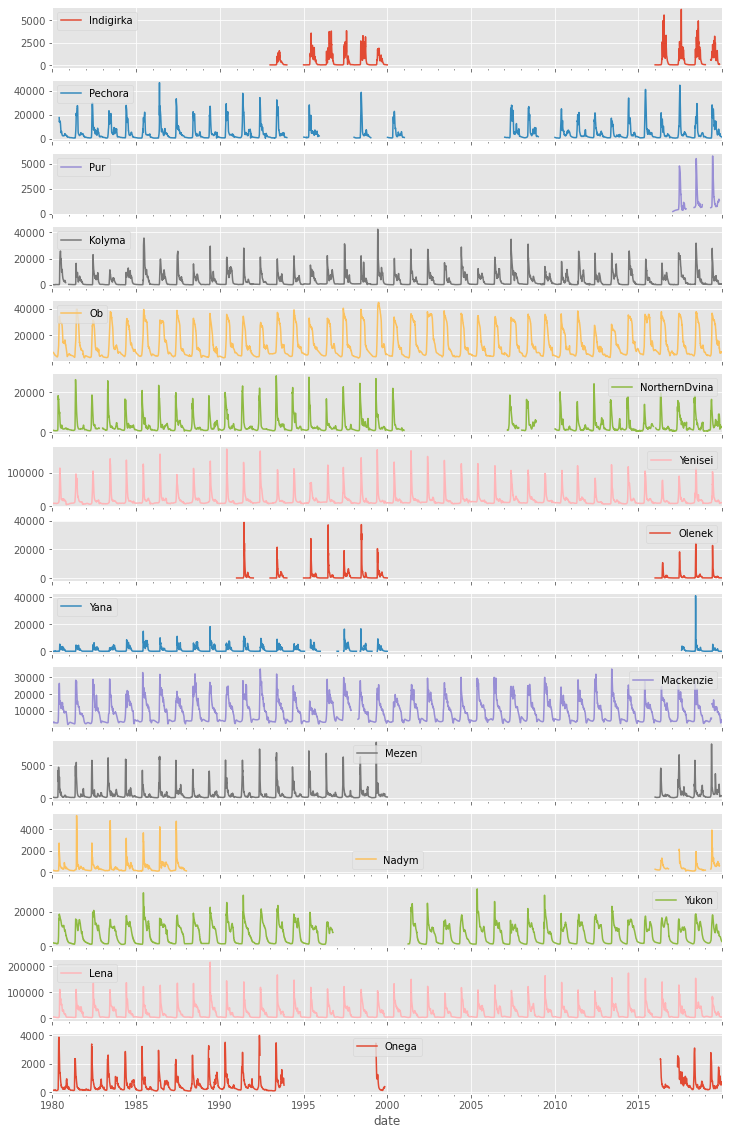

In [2]:
# Read observed data
search_path = (
    r"/home/jovyan/shared/pan_arctic_data/discharge/ArcticGRO/data/cleaned_daily/*.csv"
)
flist = glob.glob(search_path)
df_list = []
for fpath in flist:
    riv_name = os.path.split(fpath)[1].split("_")[0]
    df = pd.read_csv(fpath, parse_dates=[0])
    df.set_index("date", inplace=True)
    df.columns = [riv_name]
    df_list.append(df)
obs_df = pd.concat(df_list, axis="columns")

axes = obs_df.plot(subplots=True, figsize=(12, 20))

## 2. Identify COMID for observed catchments

Use a spatial join to assign monitoring stations in ArcticGRO to MERIT-Hydro major catchments.

In [3]:
obs_loc_csv = r"/home/jovyan/shared/pan_arctic_data/ArcticGRO_spatial_data/sampling_locations_discharge.csv"
radr_cat_shp = f"~/shared/pan_arctic_data/merit_hydro_basins/radr_cats_merged.shp"
a20_proj4_str = "+proj=stere +R=6371000.0 +lat_0=90 +lat_ts=60.0 +x_0=4180000.0 +y_0=2570000.0 +lon_0=58.0"

In [4]:
# Build dataframe of sampling locations
obs_loc_df = pd.read_csv(obs_loc_csv)
obs_loc_gdf = gpd.GeoDataFrame(
    obs_loc_df,
    geometry=gpd.points_from_xy(obs_loc_df["Lon"], obs_loc_df["Lat"], crs="epsg:4326"),
).to_crs(a20_proj4_str)

# Read MERIT-Hydro catchments
radr_cat_gdf = gpd.read_file(radr_cat_shp).to_crs(a20_proj4_str)

# Spatial join
nlocs = len(obs_loc_gdf)
obs_loc_gdf = obs_loc_gdf.sjoin(radr_cat_gdf, predicate="within")
assert nlocs == len(obs_loc_gdf)
del obs_loc_gdf["index_right"]

# Save
obs_loc_shp = r"/home/jovyan/shared/pan_arctic_data/ArcticGRO_spatial_data/sampling_locations_discharge.shp"
obs_loc_gdf.to_file(obs_loc_shp)

obs_loc_gdf.head()

/opt/conda/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/tmp/ipykernel_224/799838228.py:19: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  obs_loc_gdf.to_file(obs_loc_shp)


,River,Sampling_loc,Lat,Lon,Collection agency,data_downloaded,area_STN_km2,area_GRDC_km2,ContPerma_pc,ContDiscontPerm_pc,popdensity_p-km2,comment,NameTidy,geometry,OutCOMID,area_km2
0,Yukon,Pilot Station,61.93,-162.88,USGS,1,850596.0,831390.0,19.0,87.0,0.2,NaN,Yukon,POINT (6124999.301 4816953.001),81020021,8.362082e+05
1,Mackenzie,Arctic Red River,67.45,-133.74,Water Survery of Canada,1,1678481.0,1660000.0,13.0,42.0,0.2,NaN,Mackenzie,POINT (4662256.962 4890571.113),82000867,1.791398e+06
2,Ob',Salekhard,66.63,66.60,Roshydromet,1,2533000.0,2950000.0,1.0,4.0,8.0,NaN,Ob,POINT (4547667.559 138911.561),31006084,2.945383e+06
3,Yenisey,Igarka,67.43,86.48,Roshydromet,1,2413000.0,2440000.0,31.0,42.0,3.0,NaN,Yenisei,POINT (5311240.594 484778.545),32000794,2.569614e+06
4,Lena,Kyusyur,70.68,127.39,Roshydromet,1,2430000.0,2430000.0,77.0,90.0,0.4,kyusyur not in GRDC database. Area from https:...,Lena,POINT (6074074.943 1857686.726),34000655,2.464300e+06


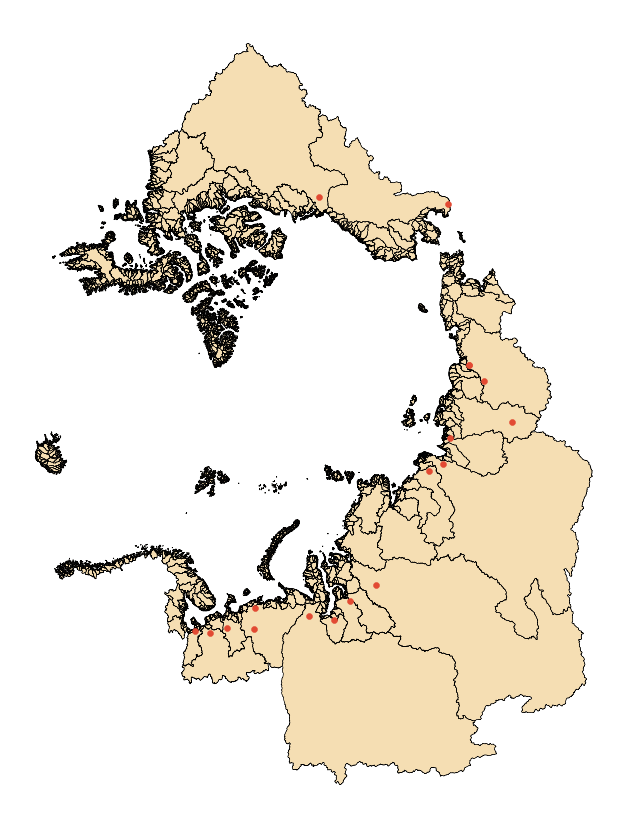

In [5]:
# Plot
ax = radr_cat_gdf.plot(figsize=(15, 15), edgecolor="k", facecolor="wheat")
obs_loc_gdf.plot(ax=ax)
ax.set_axis_off()

## 3. Get RADR data for observed catchments

Get daily modelled data from RADR for each main catchment with observations.

In [6]:
radr_path = r"/home/jovyan/shared/pan_arctic_data/discharge/RADR_v1.0.0.nc"
name_map = dict(zip(obs_loc_gdf["OutCOMID"], obs_loc_gdf["NameTidy"]))
cat_ids = obs_loc_gdf["OutCOMID"].unique()

ds = xr.open_dataset(radr_path)
ds = ds.sel(reach=cat_ids)
radr_df = ds.to_dataframe().unstack("reach")
radr_df.columns = [int(i) for i in radr_df.columns.get_level_values(1)]
radr_df.rename(name_map, inplace=True, axis="columns")
radr_df.index.name = "date"
radr_df.head()

,Yukon,Mackenzie,Ob,Yenisei,Lena,Kolyma,Onega,NorthernDvina,Mezen,Pechora,Nadym,Pur,Olenek,Yana,Indigirka
date,,,,,,,,,,,,,,,
1984-01-01,3950.173096,3378.871094,8952.445312,10851.489258,10208.205078,643.473022,86.014999,2352.587891,165.320007,3194.104980,118.849998,223.595993,351.785004,185.826996,290.862000
1984-01-02,3950.173096,3378.864990,8952.441406,10851.489258,10208.203125,643.473022,85.872002,2352.586914,165.292999,3194.104980,118.848000,223.595993,351.785004,185.826996,290.862000
1984-01-03,3899.137939,3340.862061,8870.441406,10672.846680,10062.271484,631.630981,81.374001,2327.250000,162.117996,3137.810059,117.414001,222.035995,337.123993,178.957993,278.505005
1984-01-04,3850.270996,3303.451904,8787.366211,10498.539062,9919.709961,618.999023,76.375999,2302.327881,156.447998,3082.782959,115.959999,220.453003,323.049011,172.442001,266.889008
1984-01-05,3803.260986,3266.558105,8703.269531,10328.238281,9780.322266,606.846008,72.183998,2277.069092,151.007996,3028.964111,114.487999,218.835999,309.561005,166.264999,255.964005


## 4. Compare RADR modelled data to observations

In [7]:
obs_df_long = obs_df.reset_index().melt(
    id_vars=["date"], var_name="site", value_name="q_m3ps"
)
radr_df_long = radr_df.reset_index().melt(
    id_vars=["date"], var_name="site", value_name="q_m3ps"
)
df = pd.merge(
    obs_df_long,
    radr_df_long,
    how="inner",
    on=["date", "site"],
    suffixes=["_obs", "_radr"],
)
df["month"] = df["date"].dt.month
df.dropna(how="any", inplace=True)
df.head()

,date,site,q_m3ps_obs,q_m3ps_radr,month
3288,1993-01-01,Indigirka,4.62,79.848000,1
3289,1993-01-02,Indigirka,4.48,78.029999,1
3290,1993-01-03,Indigirka,4.34,76.291000,1
3291,1993-01-04,Indigirka,4.20,74.625000,1
3292,1993-01-05,Indigirka,4.06,73.028999,1


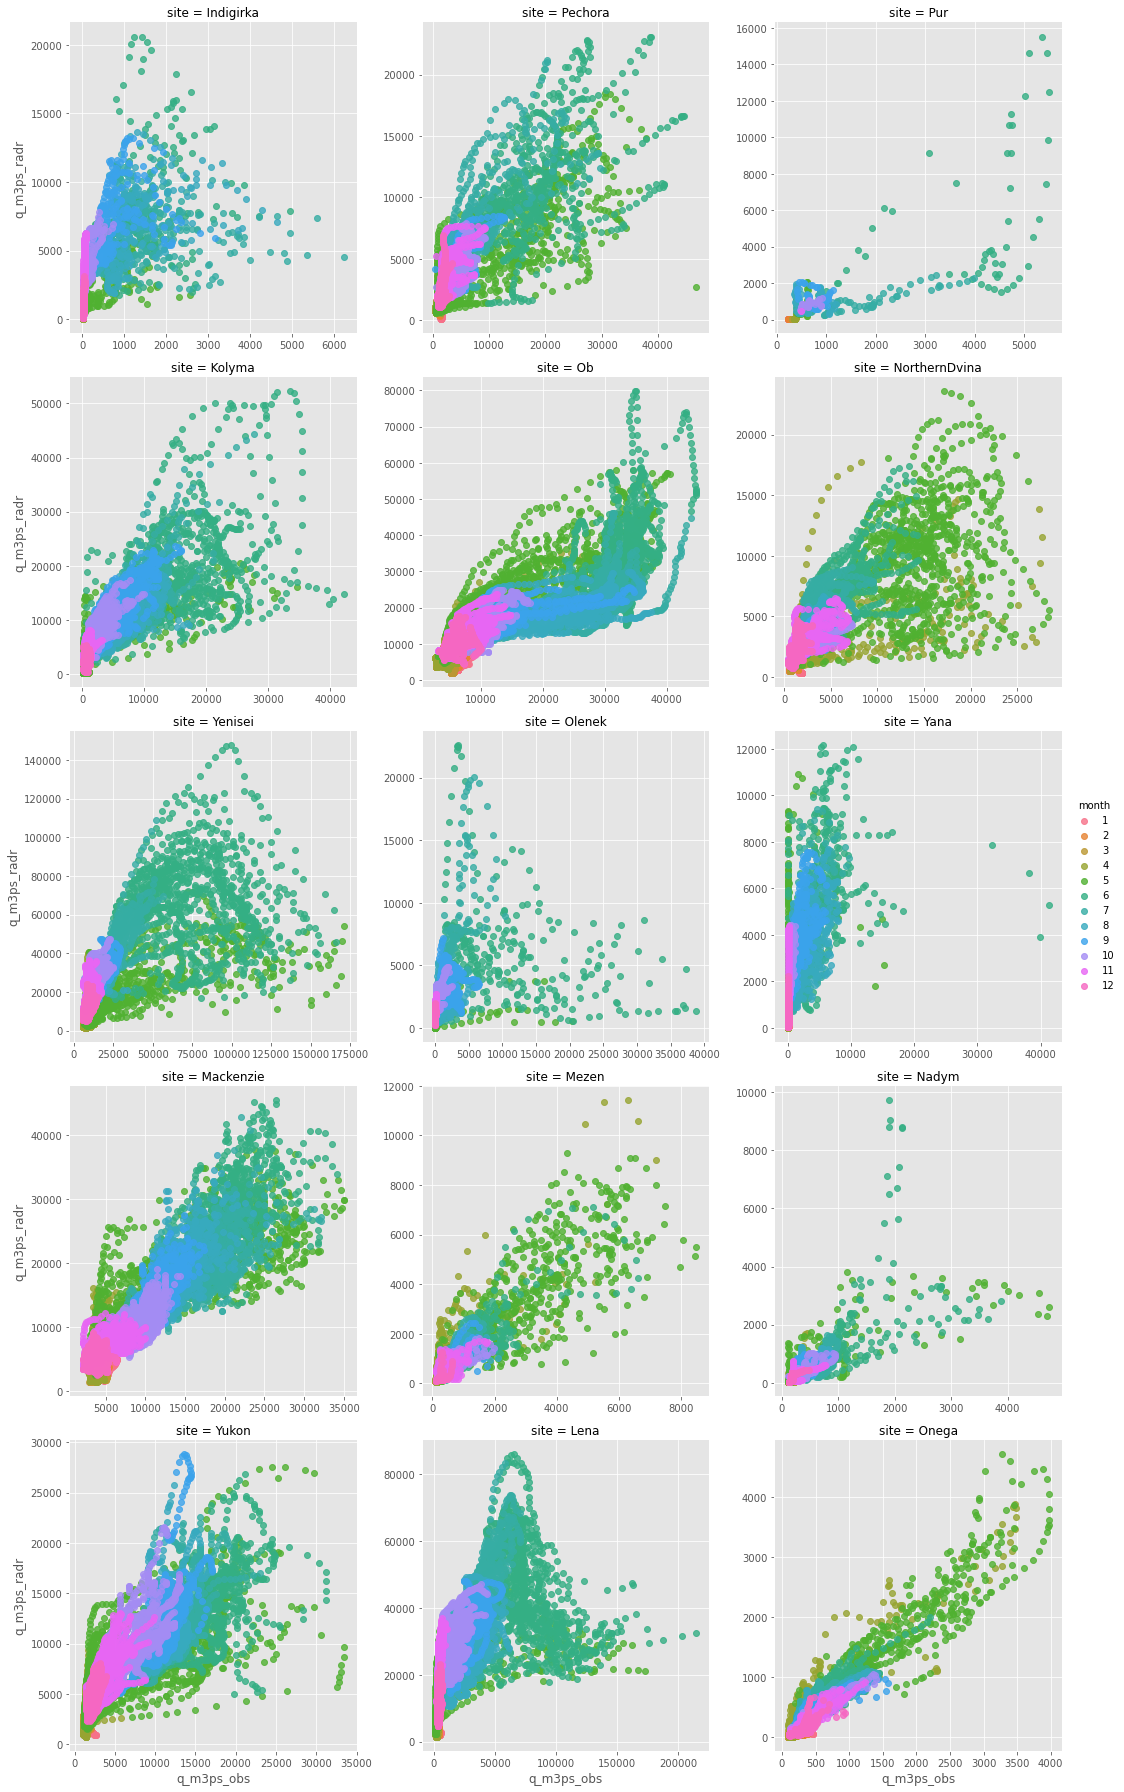

In [8]:
# Scatter plot with points coloured by month
sn.lmplot(
    data=df,
    x="q_m3ps_obs",
    y="q_m3ps_radr",
    hue="month",
    fit_reg=False,
    col="site",
    col_wrap=3,
    aspect=1,
    facet_kws={"sharex": False, "sharey": False},
)

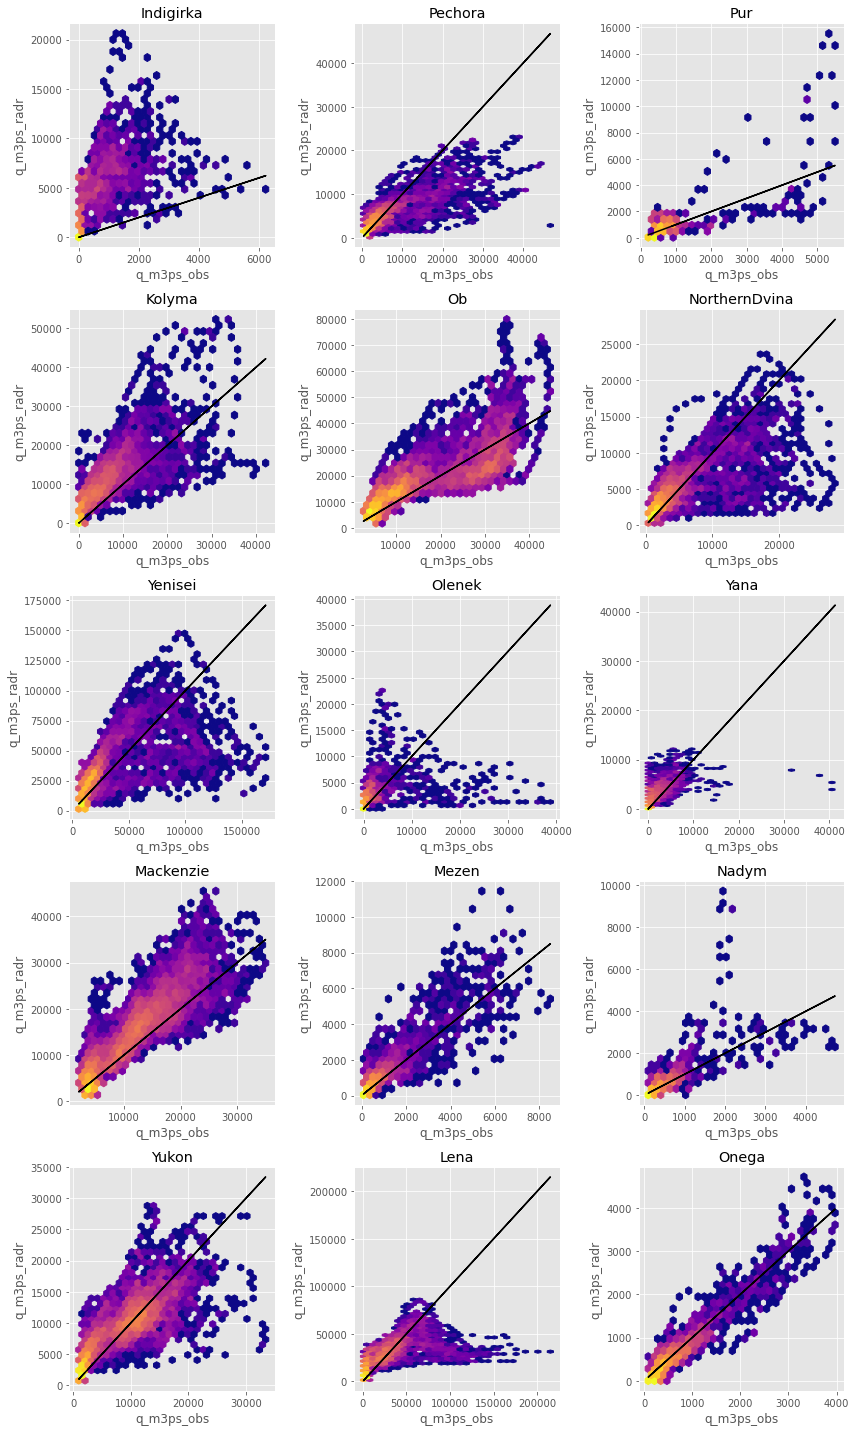

In [9]:
# Hexbin plot to reduce noise
fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(12, 20))
axes = axes.flatten()

for idx, site in enumerate(df["site"].unique()):
    df2 = df.query("site == @site")
    axes[idx].hexbin(
        data=df2,
        x="q_m3ps_obs",
        y="q_m3ps_radr",
        gridsize=30,
        bins="log",
        cmap="plasma",
    )
    axes[idx].plot(df2["q_m3ps_obs"], df2["q_m3ps_obs"], "k-")
    axes[idx].set_title(site)
    axes[idx].set_xlabel("q_m3ps_obs")
    axes[idx].set_ylabel("q_m3ps_radr")
plt.tight_layout()